<a href="https://colab.research.google.com/github/kishiyamat/la-kentei-yaminabe/blob/main/notebooks/hearing_loss_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 難聴のシミュレーション

1. 前準備: ライブラリなどのインストールと関数定義
2. 設定: 自分の年齢とシミュレーションしたい相手の年齢
3. 録音とシミュレーション

### 前準備

In [1]:
! pip install praat-parselmouth
! pip install pydub

from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
import pandas as pd
from plotnine import ggplot, aes, geom_line, labs, theme_minimal, scale_y_reverse, scale_x_log10, ggsave
import parselmouth
import soundfile as sf
from IPython.display import display, Audio
import numpy as np
import librosa
import io
from IPython.display import Audio


# 音声を保存する方法は以下のGist, Notebookを参照
# https://gist.github.com/tam17aki/8bfa2a42dab0061ee2641aed32dd1d30
# https://colab.research.google.com/github/espnet/notebook/blob/master/espnet2_asr_realtime_demo.ipynb

RECORD = """
const sleep = time => new Promise(resolve => setTimeout(resolve, time));
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader();
  reader.onloadend = e => resolve(e.srcElement.result);
  reader.readAsDataURL(blob);
});

var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true });

  // MediaRecorderをWebM形式で初期化
  const options = { mimeType: "audio/webm" };
  recorder = new MediaRecorder(stream, options);

  chunks = [];
  recorder.ondataavailable = e => chunks.push(e.data);
  recorder.start();
  await sleep(time);
  recorder.onstop = async () => {
    blob = new Blob(chunks);
    text = await b2text(blob);
    resolve(text);
  };
  recorder.stop();
});
"""

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

import tempfile
from base64 import b64decode
import librosa
import soundfile as sf

def record(sec, filename='audio.wav'):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec * 1000))
  b = b64decode(s.split(',')[1])
  with open(filename, 'wb+') as f:
    f.write(b)

def from20to80(age):
    age = min(max(age, 20), 80)  # 年齢を制限
    age = age//10*10  # 20, 30, 40, ... 80に変換
    return age


### 設定

- 自分の年齢
- シミュレーションしたい相手の年齢

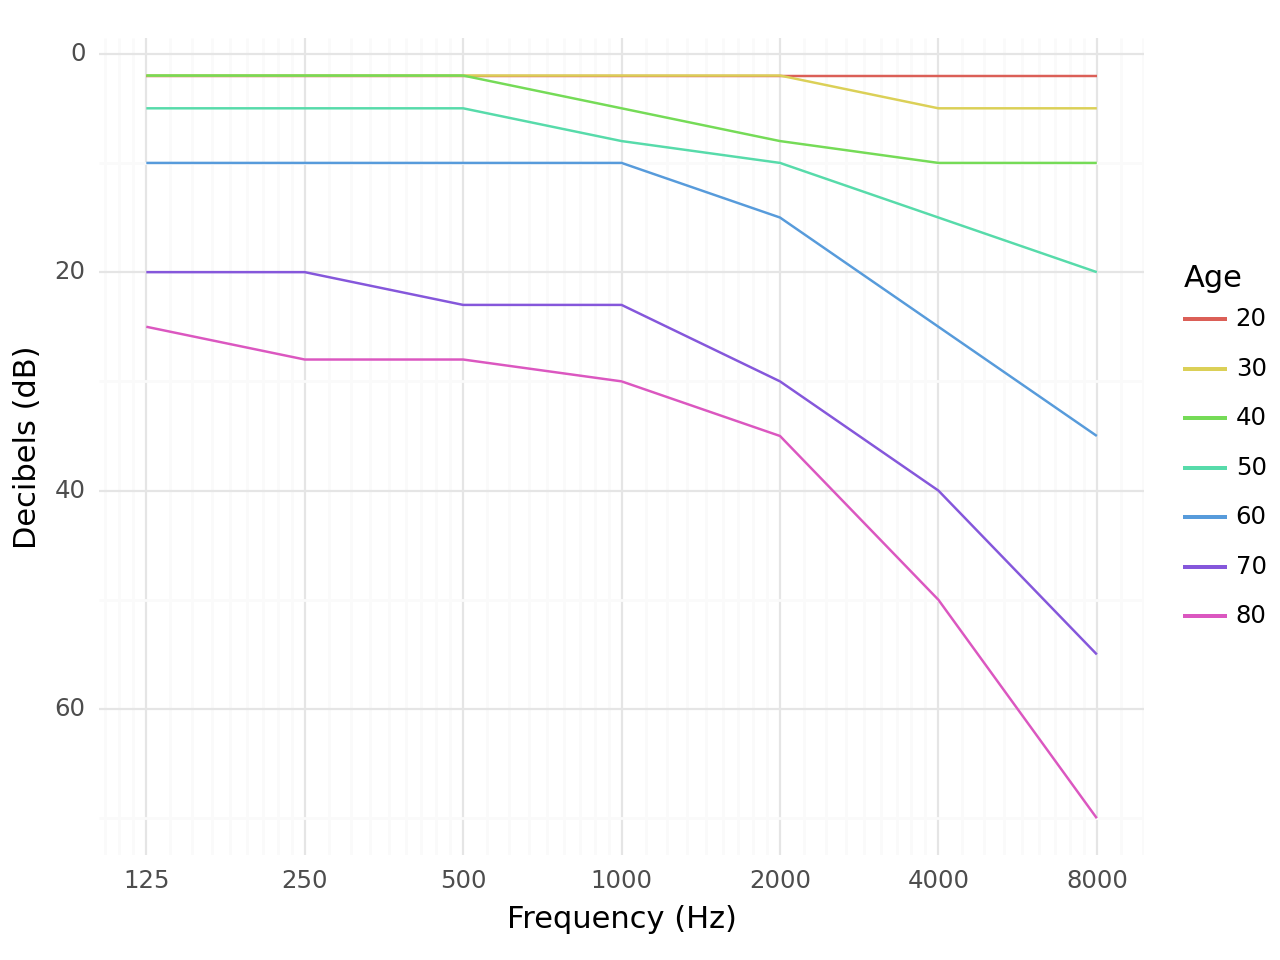

<Figure Size: (640 x 480)>

In [2]:
# 以下を変更
YOUR_AGE = 20
TARGET_AGE = 80

your_age = from20to80(YOUR_AGE)
target_age = from20to80(TARGET_AGE)

# 逆になると音量が大きくなるので止める
assert YOUR_AGE < TARGET_AGE

# データを読み込む
url = 'https://docs.google.com/spreadsheets/d/183OybKwodl-FkQsX_ReNUSskj_EPP5t4f3TQiiaKPjs/export?format=csv'
df = pd.read_csv(url)

# plotnineを使ってグラフを作成
(ggplot(df, aes(x='hz', y='db', color='factor(age)'))  # factor(age)で年齢をカテゴリとして扱う
    + geom_line()  # 線グラフ
    + labs(x='Frequency (Hz)', y='Decibels (dB)', color='Age')  # 軸ラベルと凡例タイトル
    # Apply log scale with specified ticks
    + scale_x_log10(breaks=[125, 250, 500, 1000, 2000, 4000, 8000])
    + scale_y_reverse() # This will reverse the y-axis so that smaller values are at the top
    + theme_minimal()  # ミニマルなテーマを適用
)

In [3]:
bins = list(df.query("age == @target_age")["hz"].values)
# 上の周波数で以下のdBを減衰させる
delta_dB = df.query("age == @target_age")["db"].values - df.query("age == @your_age")["db"].values
delta_dB

array([23, 26, 26, 28, 33, 48, 68])

## 録音

3秒の間にシミュレーションしたい発話を吹き込む

In [4]:
save_name = "compare.wav"
record(3, save_name)
rate = 16000
display(Audio(save_name, rate=rate))

y, sr = librosa.load(save_name, sr=rate)

<IPython.core.display.Javascript object>

<ipython-input-4-5201a5f6cded>:6: UserWarning: PySoundFile failed. Trying audioread instead.
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.


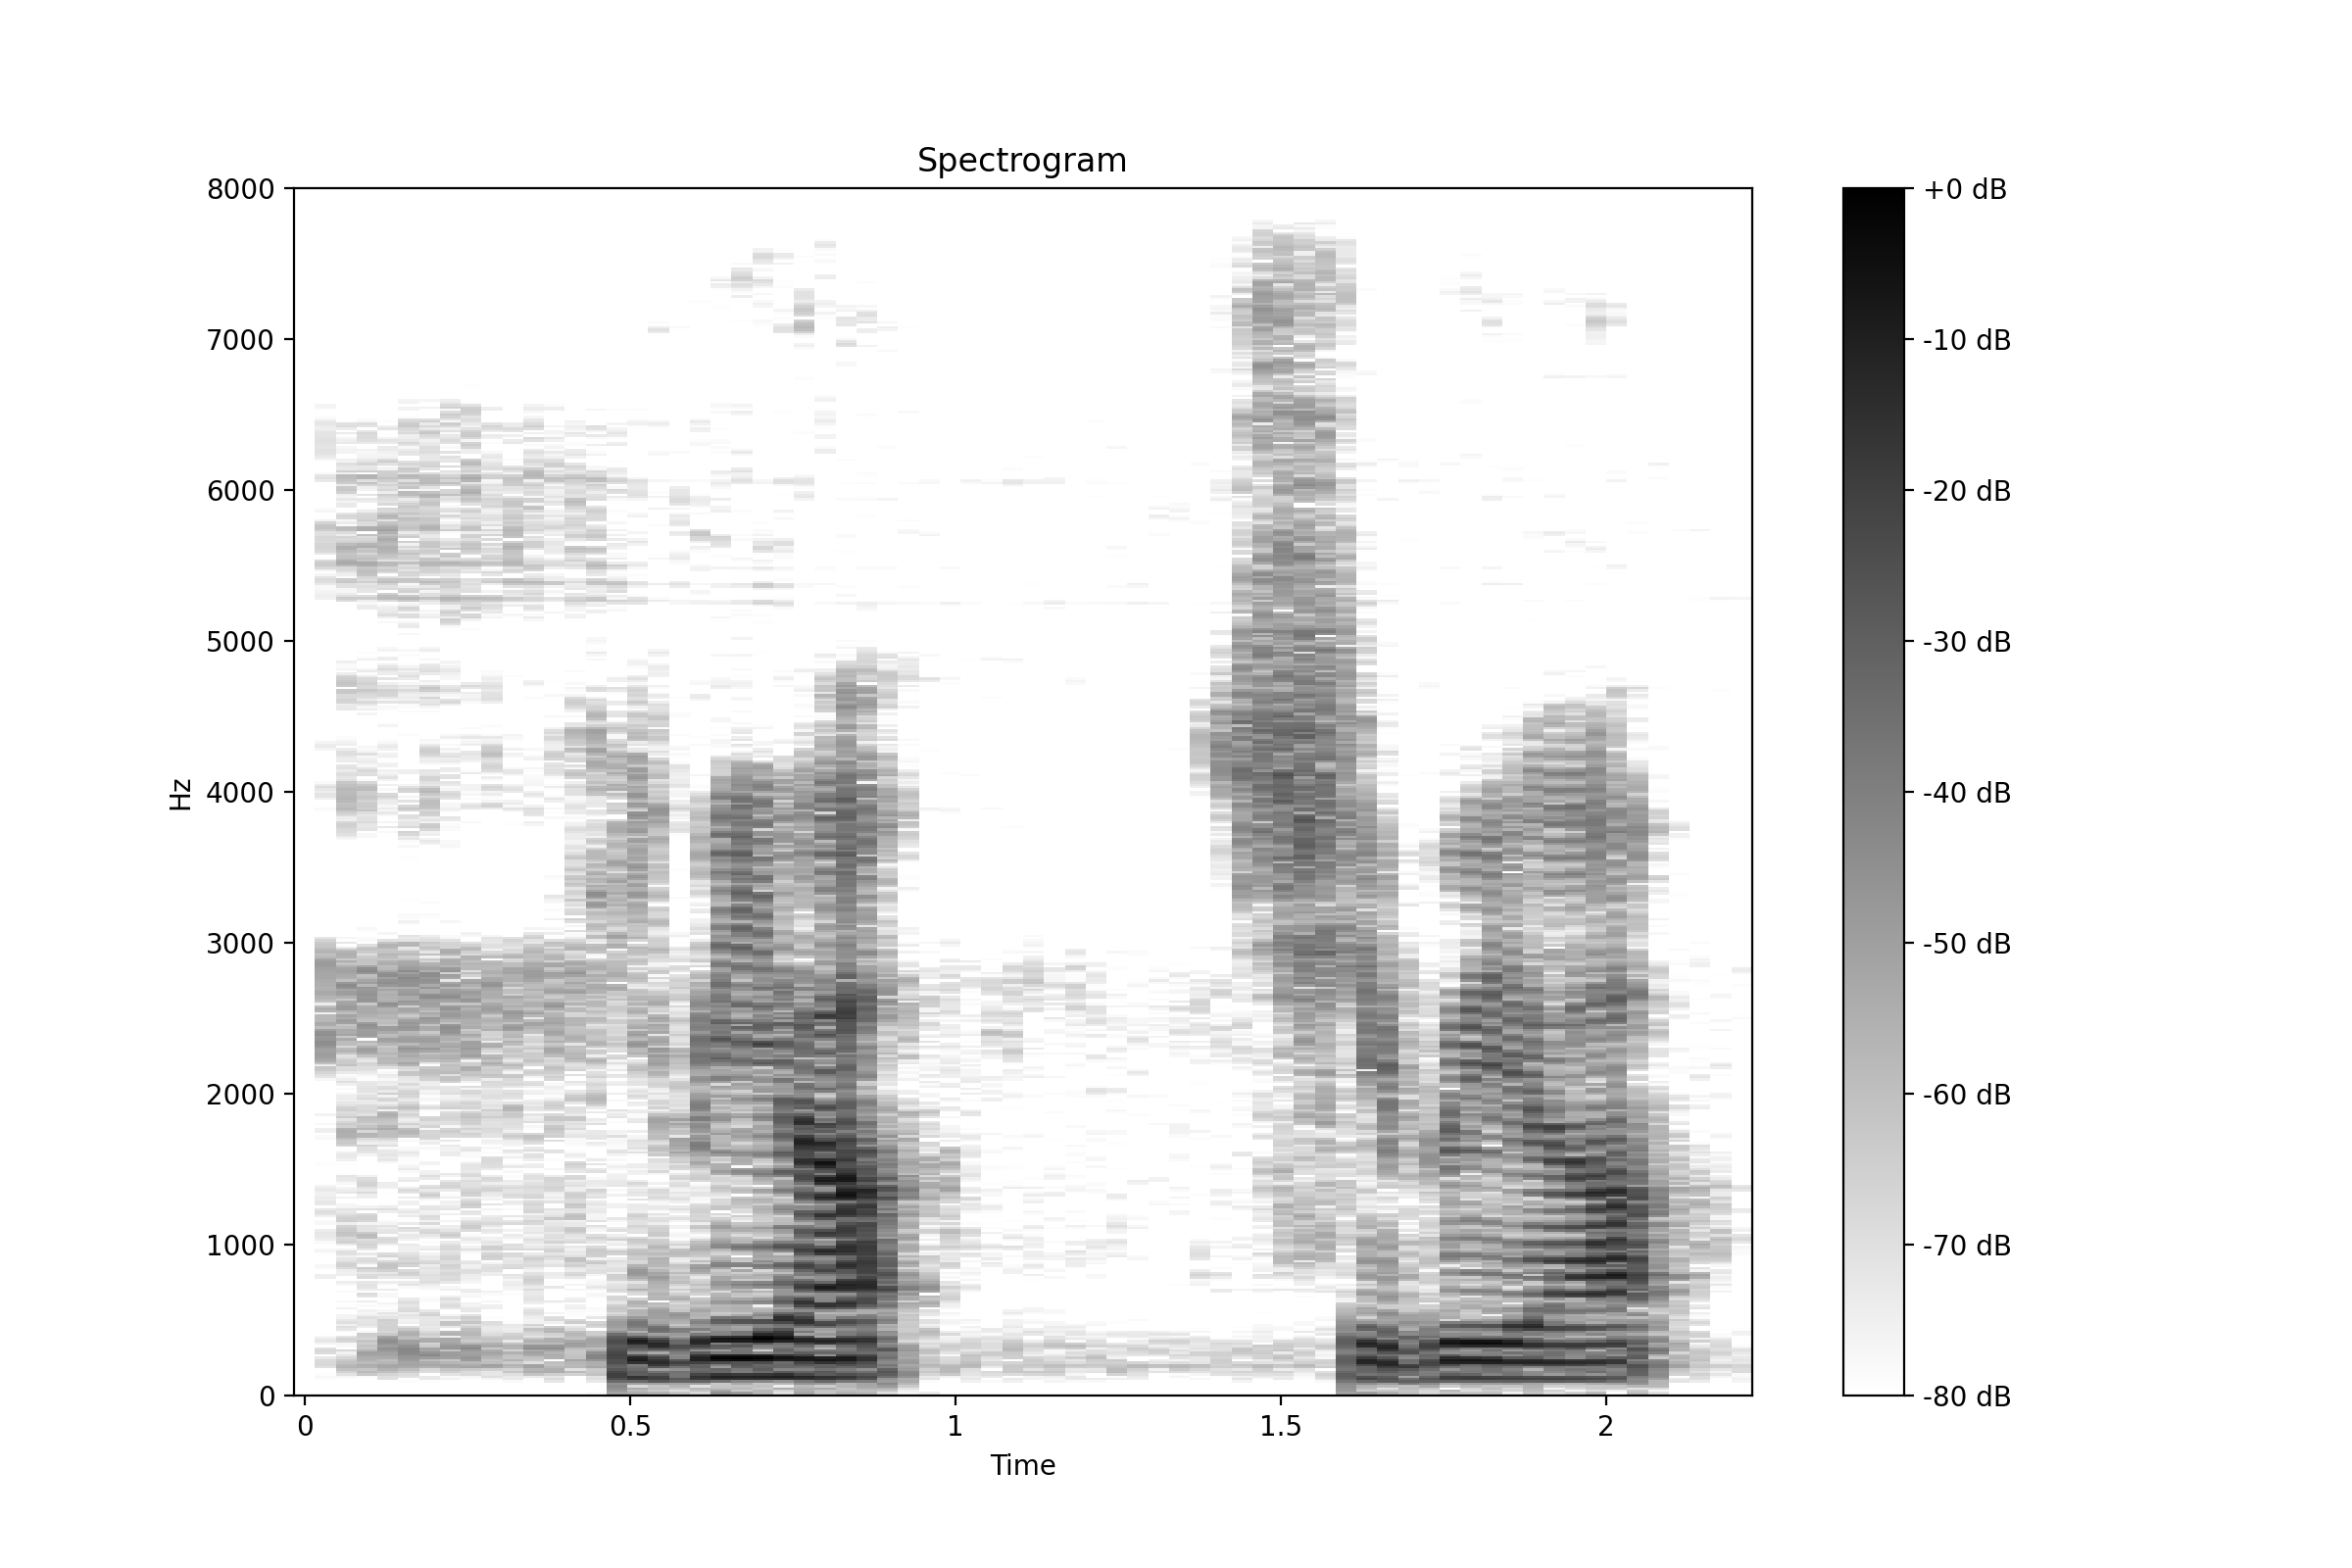

In [5]:
# 高速フーリエ変換 (FFT)
window_size = 1024
hop_length = 512
stft = librosa.stft(y, n_fft=window_size, hop_length=hop_length)

stft = librosa.stft(y, n_fft=window_size, hop_length=hop_length)
frequency_bins = np.linspace(0, sr, window_size//2 + 1)  # Compute the frequency bins
D = librosa.amplitude_to_db(np.abs(stft), ref=np.max)

# Plotting the spectrogram with the frequency limit up to 8000 Hz
plt.figure(figsize=(12, 8))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='linear', cmap='gray_r')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.ylim(0, 8000)  # Set the frequency limit up to 8000 Hz
plt.show()

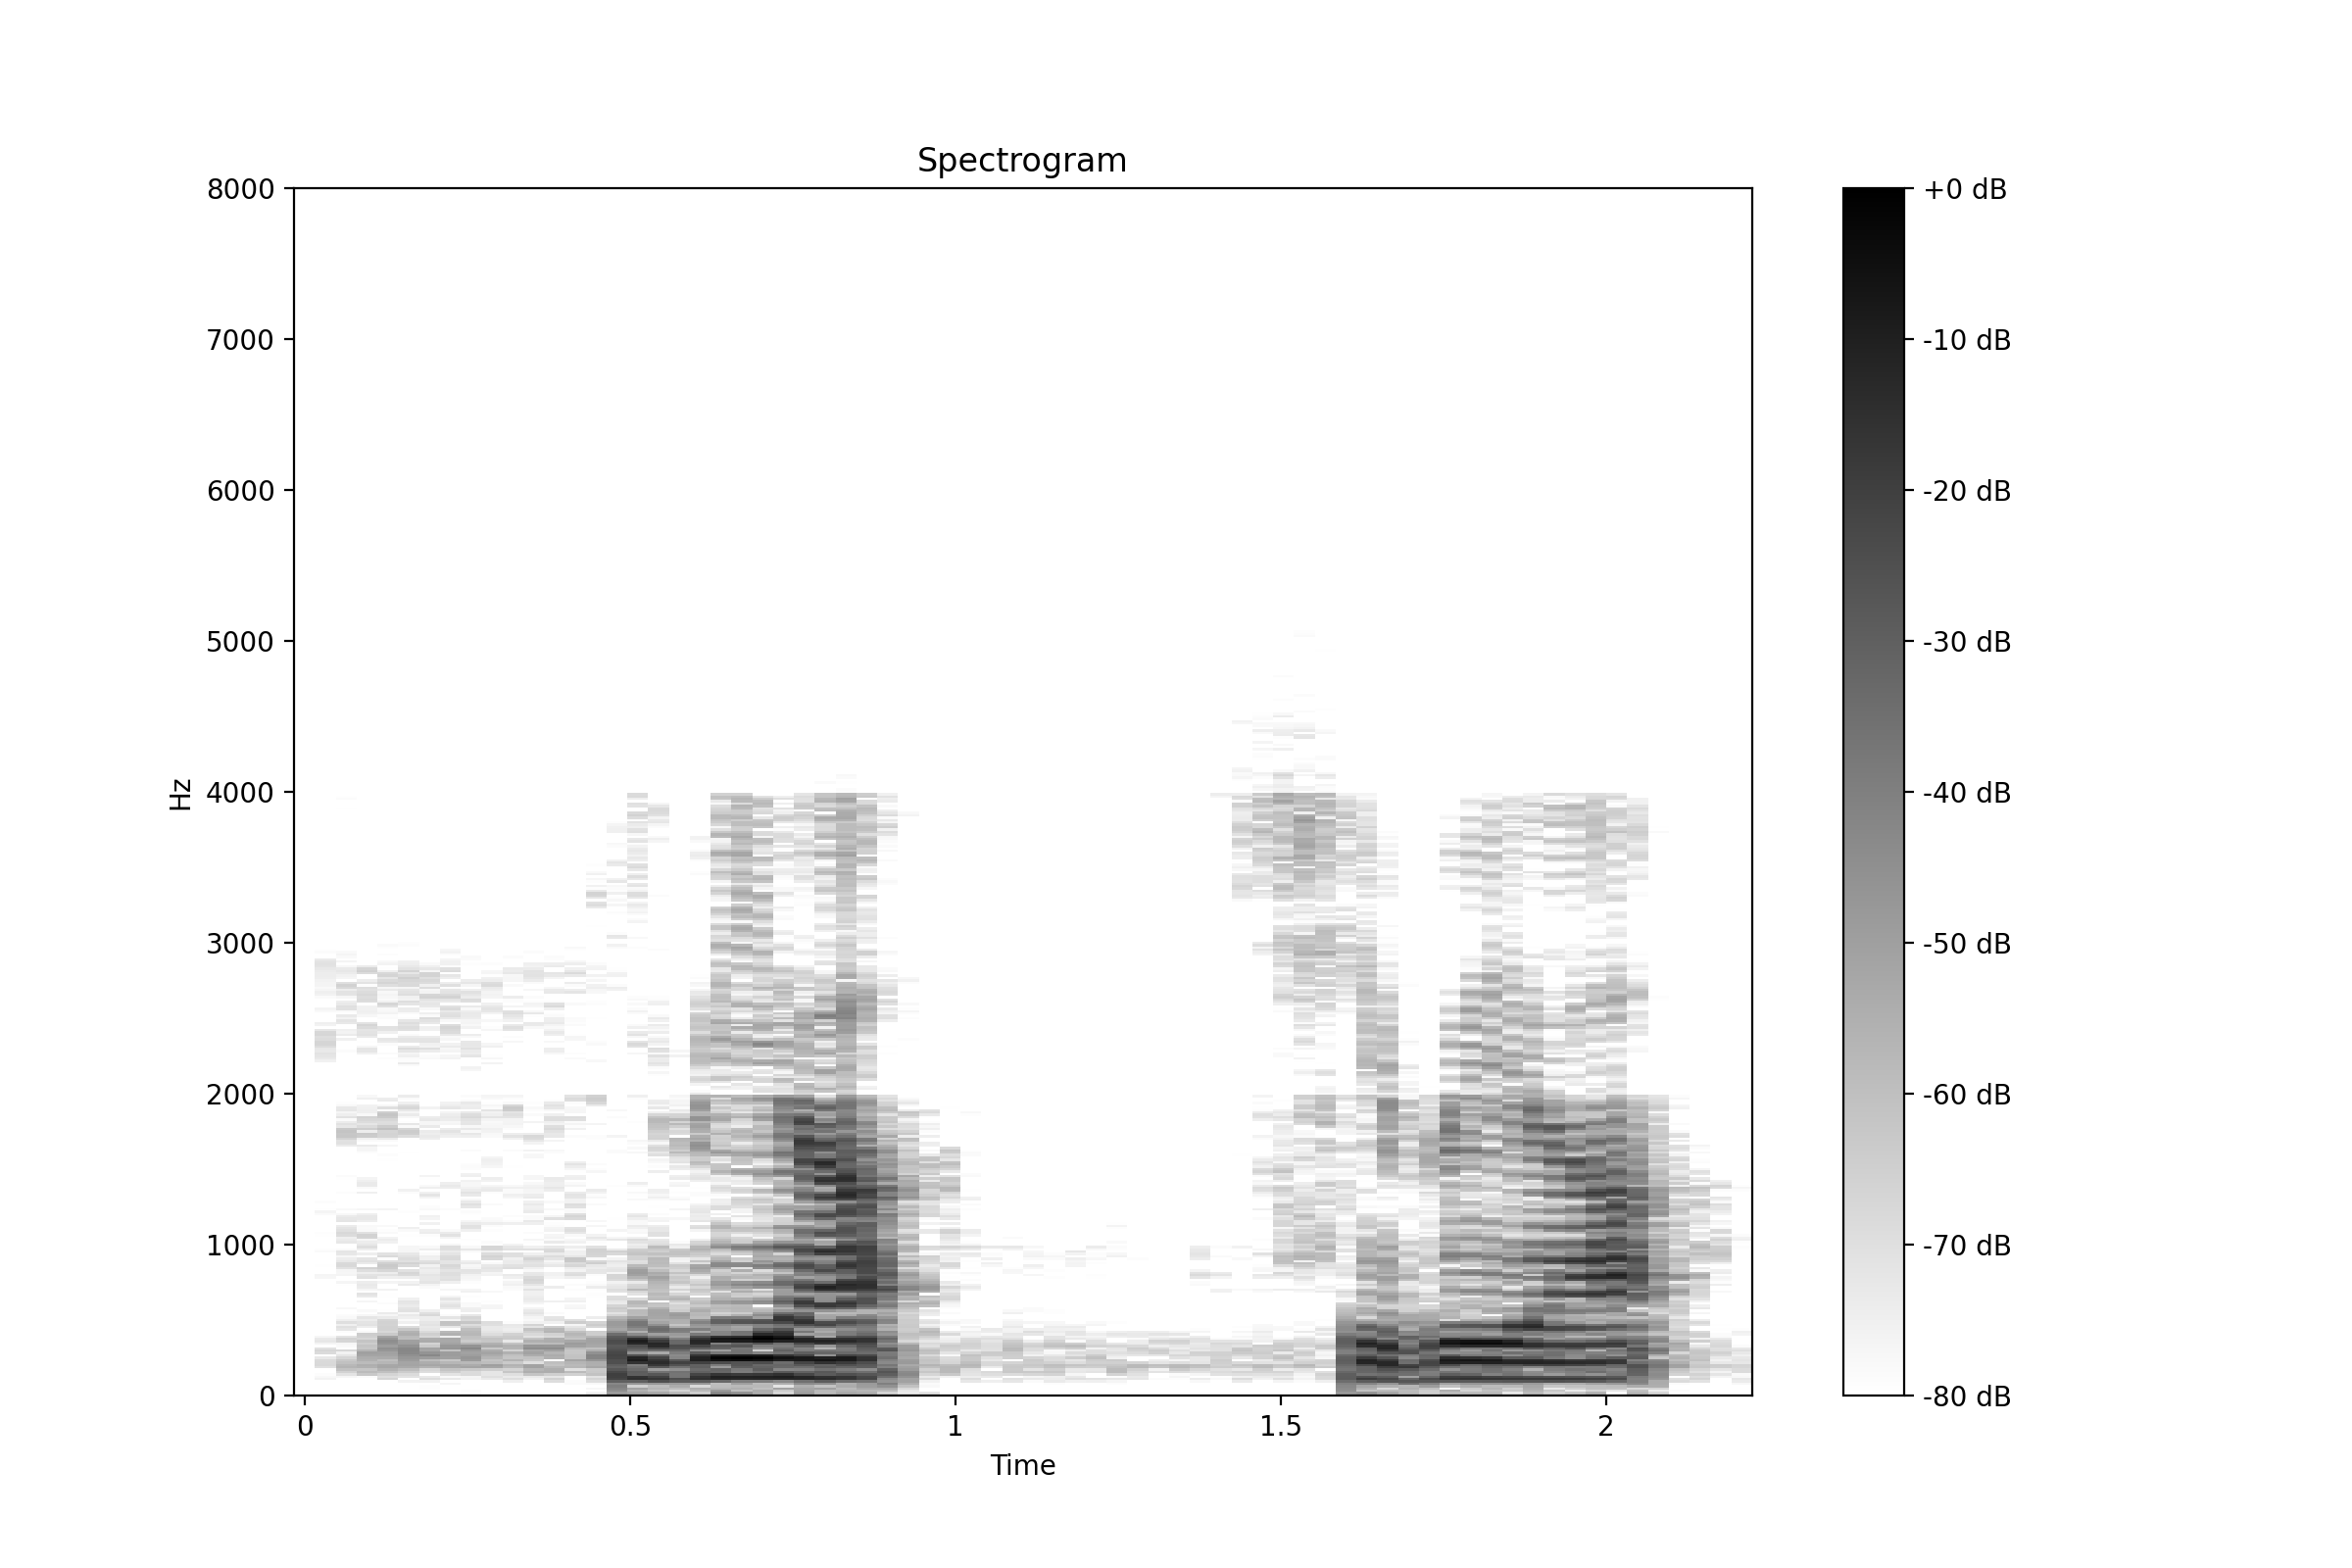

In [6]:
# 周波数ビンの計算
frequency_bins = np.linspace(0, sr/2, num=int(1 + window_size // 2))

# 減衰させる周波数帯と減衰率
frequency_ranges = np.array([0] + bins)
attenuation_factors = 10 ** (-delta_dB / 20)  # dBの減衰は対数スケール

# 周波数帯域ごとに減衰を適用
for i in range(len(frequency_ranges) - 1):
    # 各帯域の開始ビンと終了ビンを取得
    start_freq, end_freq = frequency_ranges[i], frequency_ranges[i + 1]
    start_bin = np.searchsorted(frequency_bins, start_freq)
    end_bin = np.searchsorted(frequency_bins, end_freq)
    # 範囲をスライスして、該当するビンの振幅に減衰率を適用
    stft[start_bin:end_bin, :] *= attenuation_factors[i]

# 変更されたSTFT行列を逆変換して音声信号に戻す
y_attenuated = librosa.istft(stft, hop_length=hop_length)

frequency_bins = np.linspace(0, sr, window_size//2 + 1)  # Compute the frequency bins
D = librosa.amplitude_to_db(np.abs(stft), ref=np.max)

# Plotting the spectrogram with the frequency limit up to 8000 Hz
plt.figure(figsize=(12, 8))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='linear', cmap='gray_r')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.ylim(0, 8000)  # Set the frequency limit up to 8000 Hz
plt.show()

In [7]:
# 処理後の音声データを再生
Audio(y_attenuated, rate=sr)